In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

# SVM

In [3]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.kernel import Kernel
from classifiers.convex.svm import BinarySVM
from classifiers.visualization import Plot_SVM, Plot_Data


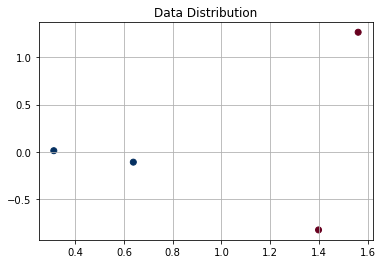

In [4]:
dl = ToyBlochSphereLoader(gap=np.pi/5)
ds = DataScaler('standard')
np.random.seed(30)
X, y = dl(4, 0.1)
kernel = Kernel('SingleQubit')
Plot_Data(X, y).plot()


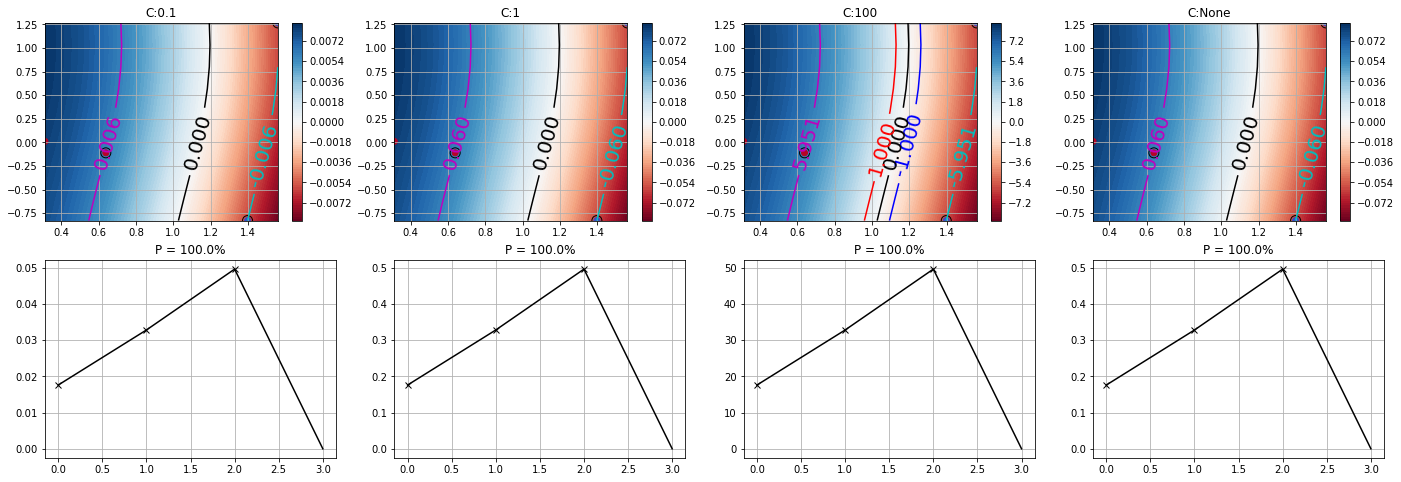

In [5]:
svms = [BinarySVM(kernel, C=C, k=0.1, mutation='REDUCED_QASVM') for C in [0.1, 1, 100, None]]
[svm.fit(X, y) for svm in svms]
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
for n in range(4):
    ax0 = axes[0][n]
    ax1 = axes[1][n]
    plot = Plot_SVM(svms[n])
    plot.plot_boundary(ax=ax0, fig=fig)
    plot.plot('alpha', ax=ax1)
    ax0.set_title(f'C:{svms[n].C}')
    if svms[n].status == 'optimal':
        ax1.set_title(f'P = {100*svms[n].accuracy(X, y)}%')
    else:
        ax1.set_title('Not Optimal')
    

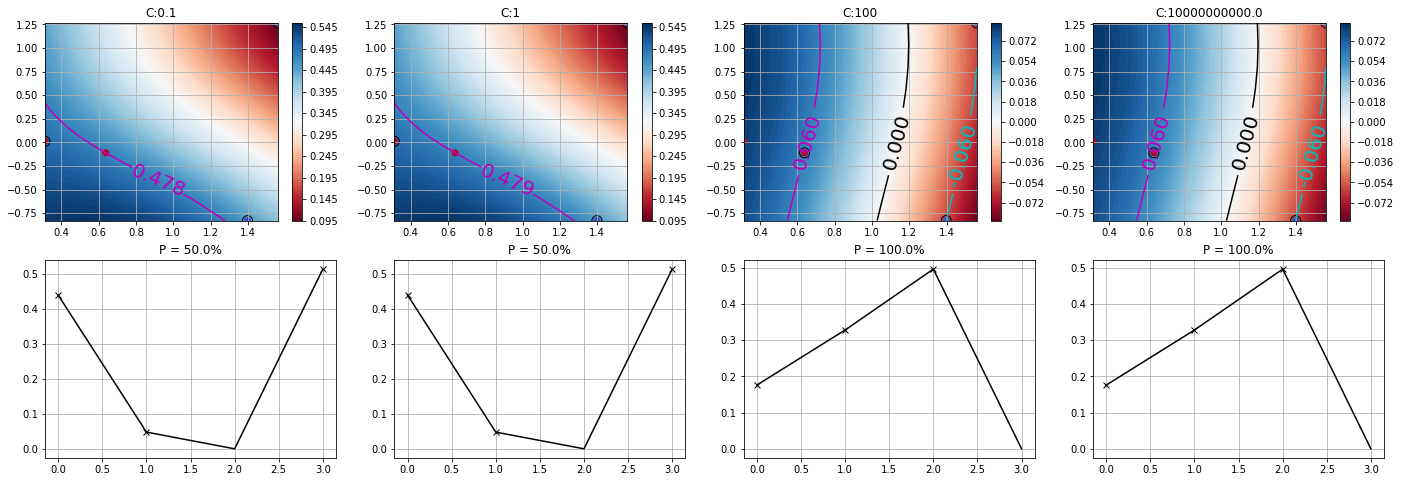

In [6]:
svms = [BinarySVM(kernel, C=C, k=0.1, mutation='REDUCED_primal_QASVM') for C in [0.1, 1, 100, 1e10]]
[svm.fit(X, y) for svm in svms]
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
for n in range(4):
    ax0 = axes[0][n]
    ax1 = axes[1][n]
    plot = Plot_SVM(svms[n])
    plot.plot_boundary(ax=ax0, fig=fig)
    plot.plot('alpha', ax=ax1)
    ax0.set_title(f'C:{svms[n].C}')
    if svms[n].status == 'optimal':
        ax1.set_title(f'P = {100*svms[n].accuracy(X, y)}%')
    else:
        ax1.set_title('Not Optimal')

In [7]:
svm = BinarySVM(kernel, C=None, k=0.1, mutation='REDUCED_QASVM')
svm.fit(X, y)

# QASVM

In [8]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.quantum.qasvm import QASVM, BlochSphereQASVM, QASVM
from classifiers.visualization import Plot_Log_From_SPSA, Plot_Data
from classifiers.utils import get_optimizer_logger
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator

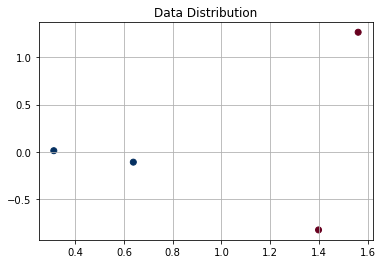

In [9]:
dl = ToyBlochSphereLoader(gap=np.pi/5)
np.random.seed(30)
X, y = dl(4, 0.1)
Plot_Data(X, y).plot()

In [10]:
var_form = RealAmplitudes(2, reps=5)
feature_map = TwoLocal(1, ['ry', 'rz'], skip_final_rotation_layer=True, reps=1)
optimizer = SPSA(maxiter=2**14, last_avg=2**8)
logger = get_optimizer_logger(optimizer)
quantum_instance = QuantumInstance(backend=QasmSimulator(), shots=2**18)


In [11]:
qasvm = BlochSphereQASVM(var_form=var_form, optimizer=optimizer, training_data=X, training_label=y, quantum_instance=quantum_instance, C=100, k=0.1).primal
qasvm.run()
qasvm.accuracy(X, y)

0.75

In [12]:
import dill
import pathlib
import uuid
dill.dump_session(logger.handlers[-1].baseFilename.split('.')[0]+'.dill')


In [1]:
import dill

import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)
import pathlib

p = pathlib.Path.home()/'QUIC-Projects'/'exp_logs'
dill.load_session(max(p.glob('*.dill'), key=lambda p: p.stat().st_ctime))

In [3]:
svm = BinarySVM(kernel, C=100, k=0.1, mutation='REDUCED_primal_QASVM')
svm.fit(X, y)

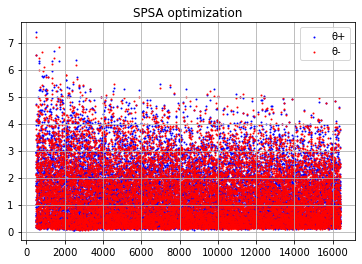

In [4]:
Plot_Log_From_SPSA().plot(min_step=500)

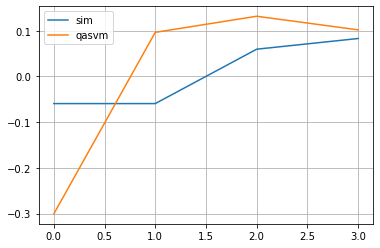

In [5]:
plt.plot(svm.f(X), label='sim')
plt.plot(qasvm.f(X), label='qasvm')
plt.legend()
plt.grid()

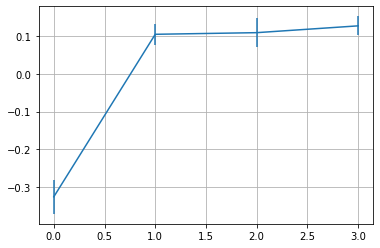

In [6]:
res = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(len(res.mean(axis=0))), res.mean(axis=0), yerr=2*res.std(axis=0))
plt.grid()